In [17]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_video
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
from model_package import VideoDataset, resize_tensor, create_paths_labels, load_model, update_plot

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Training Path

In [18]:
train_file = [
    "/Users/melvinkisam/Documents/python-workspace/notts-dissertation/badminton-rally-classification/dataset-creation/dataset/training-input/i3D/match_1-sb.txt",
    "/Users/melvinkisam/Documents/python-workspace/notts-dissertation/badminton-rally-classification/dataset-creation/dataset/training-input/i3D/match_2-sb.txt",
    "/Users/melvinkisam/Documents/python-workspace/notts-dissertation/badminton-rally-classification/dataset-creation/dataset/training-input/i3D/match_3-sb.txt",
    "/Users/melvinkisam/Documents/python-workspace/notts-dissertation/badminton-rally-classification/dataset-creation/dataset/training-input/i3D/match_4-sb.txt",
    "/Users/melvinkisam/Documents/python-workspace/notts-dissertation/badminton-rally-classification/dataset-creation/dataset/training-input/i3D/match_5-sb.txt",
    "/Users/melvinkisam/Documents/python-workspace/notts-dissertation/badminton-rally-classification/dataset-creation/dataset/training-input/i3D/match_6-sb.txt",
    "/Users/melvinkisam/Documents/python-workspace/notts-dissertation/badminton-rally-classification/dataset-creation/dataset/training-input/i3D/match_7-sb.txt",
]
val_file = [
    "/Users/melvinkisam/Documents/python-workspace/notts-dissertation/badminton-rally-classification/dataset-creation/dataset/training-input/i3D/match_8-sb.txt",
    "/Users/melvinkisam/Documents/python-workspace/notts-dissertation/badminton-rally-classification/dataset-creation/dataset/training-input/i3D/match_9-sb.txt",
]

Data Loaders

In [19]:
trainPaths, trainLabels = create_paths_labels(train_file)
valPaths, valLabels = create_paths_labels(val_file)

transform = transforms.Compose([
    transforms.Lambda(lambda x: resize_tensor(x, size=(224, 224)))
])

train_dataset = VideoDataset(trainPaths, trainLabels, transform)
val_dataset = VideoDataset(valPaths, valLabels, transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [20]:
from collections import Counter

label_counts = Counter(trainLabels)

print("Train class distribution (no of clips):")
for label, count in sorted(label_counts.items()):
    print(f"Class {label}: {count} samples")

Train class distribution (no of clips):
Class 0: 418 samples
Class 1: 458 samples
Class 2: 36 samples
Class 3: 13 samples
Class 4: 27 samples


Load Model

In [21]:
model = load_model('/Users/melvinkisam/Documents/python-workspace/notts-dissertation/badminton-rally-classification/model-training/models/i3d_resnet50_v1_kinetics400.yaml', num_classes=5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Model Training

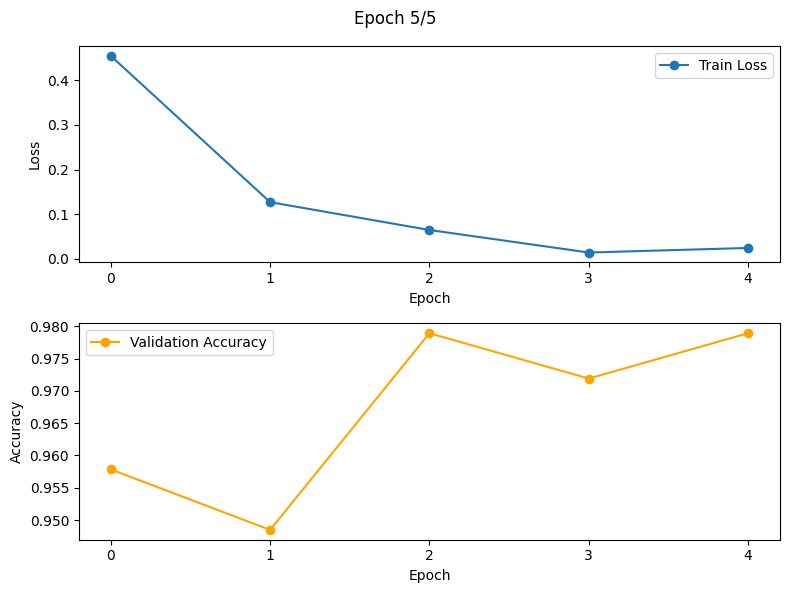

In [22]:
from tqdm import tqdm
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

num_epochs = 5
train_losses = []
val_accuracies = []

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    start = time.time()

    # Training
    model.train()
    total_loss = 0.0
    batch_bar = tqdm(train_loader, desc=f"Training Epoch {epoch}", leave=False)

    for videos, labels in batch_bar:
        videos, labels = videos.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * videos.size(0)
        batch_bar.set_postfix(loss=loss.item())

    epoch_loss = total_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    correct, total = 0, 0

    all_preds = []
    all_true = []

    with torch.no_grad():
        val_bar = tqdm(val_loader, desc="Validating...", leave=False)
        for videos, labels in val_bar:
            videos, labels = videos.to(device), labels.to(device)
            outputs = model(videos)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_true.extend(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # print("Output shape:", outputs.shape)

    accuracy = correct / total
    val_accuracies.append(accuracy)

    # Summary
    print(f"Loss: {epoch_loss:.4f} | Val Acc: {accuracy:.4f} | Time: {time.time() - start:.2f}s")

    # Live plot
    update_plot(epoch, train_losses, val_accuracies, num_epochs)

Final Validation

Inference: 100%|██████████| 107/107 [26:28<00:00, 14.85s/it]  


Inference Accuracy: 97.89%


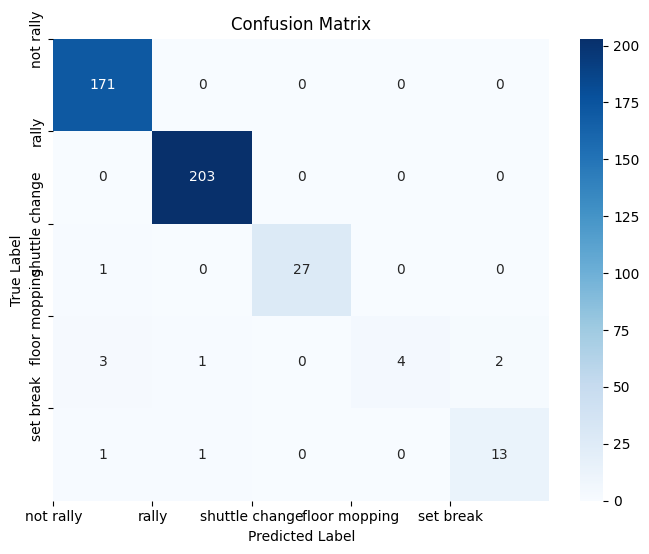

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Inference
model.eval()
final_preds = []
final_labels = []

with torch.no_grad():
    for videos, labels in tqdm(val_loader, desc="Inference"):
        videos, labels = videos.to(device), labels.to(device)
        outputs = model(videos)

        preds = torch.argmax(outputs, dim=1)

        final_preds.extend(preds.cpu().numpy())
        final_labels.extend(labels.cpu().numpy())

# Compute accuracy
infer_accuracy = accuracy_score(final_labels, final_preds)
print(f"\nInference Accuracy: {infer_accuracy * 100:.2f}%")

class_names = ['not rally', 'rally', 'shuttle change', 'floor mopping', 'set break']

# Confusion matrix
cm = confusion_matrix(final_labels, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=range(len(class_names)), labels=class_names)
plt.yticks(ticks=range(len(class_names)), labels=class_names)
plt.show()

In [24]:
print(len(val_dataset))
print(len(final_preds))

427
427


In [25]:
label_counts = Counter(valLabels)

print("Inference class distribution (no of clips):")
for label, count in sorted(label_counts.items()):
    print(f"Class {label}: {count} samples")

Inference class distribution (no of clips):
Class 0: 171 samples
Class 1: 203 samples
Class 2: 28 samples
Class 3: 10 samples
Class 4: 15 samples


Save Model

In [ ]:
save_path = '/Users/melvinkisam/Documents/python-workspace/notts-dissertation/badminton-rally-classification/model-training/trained_models/trained_model_5.pth'
torch.save({
    'epoch': epoch,  # Save current epoch to avoid retraining from scratch
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,  # Save final training loss
}, save_path)